In [133]:
# attempt to fit a disk model to NGC1052
import numpy as np
import astropy.units as u
from radiation import *
from agnpy.synchrotron import Synchrotron
from agnpy.spectra import PowerLaw, BrokenPowerLaw
from astropy.modeling import Model
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.coordinates import Distance
import sherpa
from sherpa.fit import Fit
from sherpa.data import Data1D, Data1DInt
from sherpa.models.basic import Polynom1D, Const1D, Gauss1D, RegriddableModel1D, Exp
from sherpa.models import ArithmeticModel
from sherpa.plot import DataPlot, ModelPlot, JointPlot
from sherpa.plot import DelchiPlot, FitPlot, SplitPlot
from sherpa.plot import IntervalProjection
from sherpa.optmethods import NelderMead
from sherpa.stats import Cash, Chi2
from sherpa.astro import ui
from sherpa.models.parameter import Parameter
from sherpa.data import DataSimulFit
from sherpa.models import SimulFitModel

In [134]:
# general variables
sed_x_label = r"$\nu\,({\rm Hz})$"
sed_y_label = r"$\nu F_{\nu}\,({\rm erg}\,{\rm cm}^{-2}\,{\rm s}^{-1})$"

In [135]:
# load the data and plot them
sed_table = Table.read("data/NGC1052.fits")
x = sed_table["col1"]
y = sed_table["col3"]
yerr = sed_table["col4"]

# define the data eliminating measurements with zero error
mask_error = yerr > 0
mask_lower_limit = y > 1e-14
mask = mask_error * mask_lower_limit
x_new = sed_table["col1"][mask]
y_new = sed_table["col3"][mask]
yerr_new = sed_table["col4"][mask]

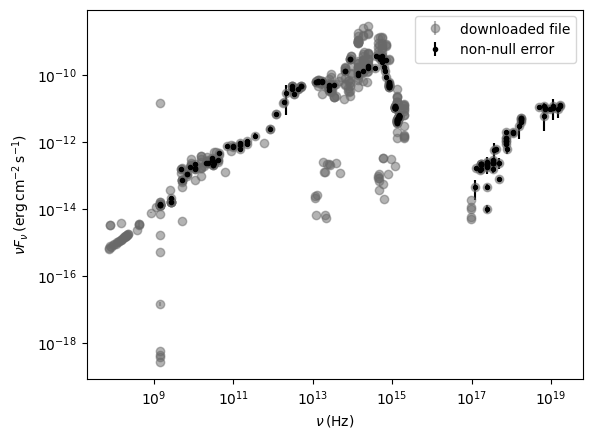

In [136]:
fig, ax = plt.subplots()
ax.errorbar(
    x,
    y,
    yerr=yerr,
    ls="",
    marker="o",
    color="dimgray",
    alpha=0.5,
    label="downloaded file"
)
ax.errorbar(
    x_new,
    y_new,
    yerr=yerr_new,
    ls="",
    marker=".",
    color="k",
    label="non-null error"
)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(sed_x_label)
ax.set_ylabel(sed_y_label)
ax.legend()
plt.show()

In [137]:
# define a new function fir the total flux
# that depends on a single array of frequencies
def nu_fnu_disk(nu, m, m_dot, d_L, norm=1):
    """Compute the total flux.
    I allow an arbitrary scaling via norm parameter, default is 1.
    """
    T_calc = compute_T_e_equilibirum(m, m_dot)

    # compute parameters
    _x_m = x_m_appendix_B(m_dot)
    _alpha_c = alpha_c(theta_from_T(T_calc * u.K), m_dot)
    # compute "break" frequency
    nu_p = vp(_x_m, m_dot, m, theta_from_T(T_calc * u.K)).value

    # let us use a switch on the three emission mechanisms
    luminosity = np.where(
        nu <= nu_p, 
        L_synch(nu, m, m_dot, _x_m, T_calc),
        L_bremms(nu, T_calc, m, m_dot) + L_compton(nu, nu_p, _alpha_c, m, m_dot, _x_m, T_calc)
    )

    sed = nu *  luminosity / (4 * np.pi * d_L**2)
    return norm * sed

In [138]:
d_L = Distance(z=0.00436).to_value("cm")
print(d_L)

5.9809837603786395e+25


5.9862145076832e+25 cm


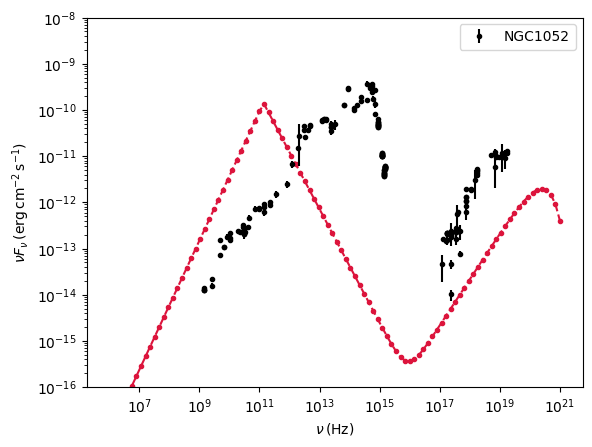

In [139]:
# let us overplot just one disk model to compare with the data
# sort of an initial guess
m = 1.5e8
m_dot = 2.78e-6
norm = 1e6
z = 0.00436
d_L = 19.4e6*3.08567758128e18*u.cm
print(d_L)

# compute the model over an arbitrary array of frequencies
nu = np.logspace(6, 21, 100)

# plot now both the model and the points with errors
fig, ax = plt.subplots()
ax.plot(
    nu,
    nu_fnu_disk(nu, m, m_dot, d_L, norm),
    color="crimson",
    ls="--",
    marker="."
)
ax.errorbar(
    x_new,
    y_new,
    yerr=yerr_new,
    ls="",
    marker=".",
    color="k",
    label="NGC1052"
)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(sed_x_label)
ax.set_ylabel(sed_y_label)
ax.legend()
ax.set_ylim([1e-16, 1e-8])
plt.show()

In [140]:
class ThermalDiskEmission(RegriddableModel1D):
    def __init__(self, name='disk emission'):

        self.log10_m = Parameter(name, 'log10_m', 8.2, min=6, max=12)
        self.log10_m_dot = Parameter(name, 'log10_m_dot', -5.5, min=-7, max=-3)
        self.norm = Parameter(name, 'log10_norm', 6, min=1, max=9)
        self.d_L = Parameter(name, 'd_L', 6e25)
        
        return RegriddableModel1D.__init__(self, name, (self.log10_m, self.log10_m_dot, self.norm, self.d_L))

    def calc(self, pars, x):
        """Calculate the model"""
        log10_m = pars[0]
        log10_m_dot = pars[1]
        log10_norm = pars[2]
        d_L = pars[3]
        # convert back logarythmic quantities
        m = 10**(log10_m)
        m_dot = 10**(log10_m_dot)
        norm = 10**(log10_norm)
        return nu_fnu_disk(nu=x, m=m, m_dot=m_dot, d_L=d_L, norm=norm)

In [141]:
class NonThermalJetEmission(RegriddableModel1D):
    """Wrapper of agnpy's synchrotron and SSC classes. 
    A broken power law is assumed for the electron spectrum.
    To limit the span of the parameters space, we fit the log10 of the parameters 
    whose range is expected to cover several orders of magnitudes (normalisation, 
    gammas, size and magnetic field of the blob). 
    """

    def __init__(self, name="ssc"):

        # EED parameters
        self.log10_k_e = Parameter(name, "log10_k_e", -2.0, min=-20.0, max=20.0)
        self.p = Parameter(name, "p", 2.1, min=-20.0, max=20.0)
        self.log10_gamma_min = Parameter(name, "log10_gamma_min", 1, min=0, max=4)
        self.log10_gamma_max = Parameter(name, "log10_gamma_max", 5, min=0, max=8)
        # source general parameters
        self.z = Parameter(name, "z", 0.00435)
        self.d_L = Parameter(name, "d_L", 6e25)
        # emission region parameters
        self.delta_D = Parameter(name, "delta_D", 10, min=-40, max=40)
        self.log10_B = Parameter(name, "log10_B", -2, min=-8, max=10)
        self.log10_R_b = Parameter(name, "log10_R_b", 16, min=10, max=20)


        RegriddableModel1D.__init__(
            self,
            name,
            (
                self.log10_k_e,
                self.p,
                self.log10_gamma_min,
                self.log10_gamma_max,
                self.z,
                self.d_L,
                self.delta_D,
                self.log10_B,
                self.log10_R_b,
            ),
        )     
        
    def calc(self, pars, x):
        """evaluate the model calling the agnpy functions"""
        (
            log10_k_e,
            p,
            log10_gamma_min,
            log10_gamma_max,
            z,
            d_L,
            delta_D,
            log10_B,
            log10_R_b,
        ) = pars

        # add units, scale quantities
        x *= u.Hz
        k_e = 10 ** log10_k_e * u.Unit("cm-3")
        gamma_min = 10 ** log10_gamma_min
        gamma_max = 10 ** log10_gamma_max
        B = 10 ** log10_B * u.G
        d_L *= u.cm
        R_b = 10 ** log10_R_b * u.cm

        sed_synch = Synchrotron.evaluate_sed_flux(
            x,
            z,
            d_L,
            delta_D,
            B,
            R_b,
            PowerLaw,
            k_e,
            p,
            gamma_min,
            gamma_max,
        )

        return sed_synch.to_value("erg cm-2 s-1")


In [142]:
# let us define an instance of the model

# distance of the source, not to be fitted
disk = ThermalDiskEmission('disk')
jet = NonThermalJetEmission('jet')

# thaw and freeze model parameters
# - disk
disk.d_L = d_L
disk.d_L.freeze()
# - jet

jet.d_L = d_L
jet.d_L.freeze()
jet.z = z
jet.z.freeze()

jet.log10_gamma_min = 1.7
jet.log10_gamma_min.freeze()
jet.log10_gamma_max = 3.5
jet.log10_gamma_max.freeze()
jet.log10_R_b = 16
jet.log10_R_b.freeze()
jet.delta_D = 11
#jet.delta_D.freeze()


jet.log10_k_e = 2
jet.p = 2.1
jet.log10_B = 0
mdl = disk + jet
print(mdl)

disk + jet
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   disk.log10_m thawed          8.2            6           12           
   disk.log10_m_dot thawed         -5.5           -7           -3           
   disk.log10_norm thawed            6            1            9           
   disk.d_L     frozen  5.98621e+25 -3.40282e+38  3.40282e+38           
   jet.log10_k_e thawed            2          -20           20           
   jet.p        thawed          2.1          -20           20           
   jet.log10_gamma_min frozen          1.7            0            4           
   jet.log10_gamma_max frozen          3.5            0            8           
   jet.z        frozen      0.00436 -3.40282e+38  3.40282e+38           
   jet.d_L      frozen  5.98621e+25 -3.40282e+38  3.40282e+38           
   jet.delta_D  thawed           11          -40           40           
   jet.log10_B  th

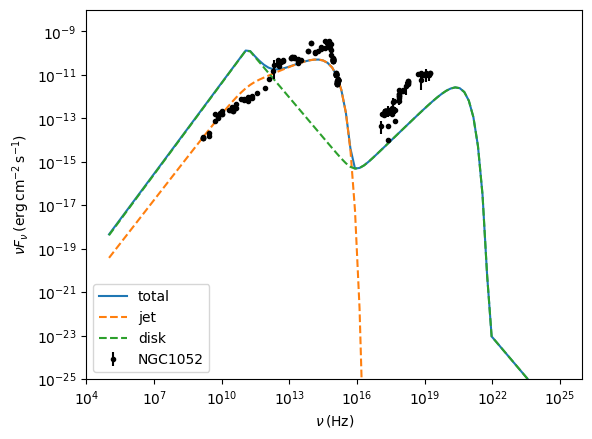

In [143]:
# just check the intial guess
fig, ax = plt.subplots()
nu = np.logspace(5, 25, 100)

ax.plot(
    nu,
    mdl(nu),
    ls="-",
    label="total",
)
ax.plot(
    nu,
    jet(nu),
    ls="--",
    label="jet",
)
ax.plot(
    nu,
    disk(nu),
    ls="--",
    label="disk",
)
ax.errorbar(
    x_new,
    y_new,
    yerr=yerr_new,
    ls="",
    marker=".",
    color="k",
    label="NGC1052"
)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(sed_x_label)
ax.set_ylabel(sed_y_label)
ax.set_ylim([1e-25, 1e-8])
#ax.plot(x_test, disk_y)
#ax.plot(x_test, jet_y)
#ax.fill_betweenx([1e-25, 1e-8], nu_min_fit, nu_max_fit, color="red", alpha=0.2)
#ax.fill_betweenx([1e-25, 1e-8], nu_min_fit2, nu_max_fit2, color="red", alpha=0.2)
ax.legend()
plt.show()

In [144]:
data = Data1D('fit example', x_new, y_new, yerr_new)
# ignore black body emission from the Galaxy
nu_min_fit = 6e13
nu_max_fit = 2e15

data.ignore(nu_min_fit, nu_max_fit)


In [145]:

f = Fit(data, mdl, stat=Chi2())
res = f.fit()
print(res.format())

Method                = levmar
Statistic             = chi2
Initial fit statistic = 1.3508e+10
Final fit statistic   = 238571 at function evaluation 112
Data points           = 107
Degrees of freedom    = 100
Probability [Q-value] = 0
Reduced statistic     = 2385.71
Change in statistic   = 1.35077e+10
   disk.log10_m   9.45946      +/- 0.0178971   
   disk.log10_m_dot   -4.80848     +/- 0.0674715   
   disk.log10_norm   2.57687      +/- 0.0597957   
   jet.log10_k_e   2            +/- 0           
   jet.p          2.1          +/- 0           
   jet.delta_D    11           +/- 0           
   jet.log10_B    0            +/- 0           


In [146]:
f2 = Fit(data, disk, stat=Chi2())
res2 = f2.fit()
print(res2.format())

Method                = levmar
Statistic             = chi2
Initial fit statistic = 238571
Final fit statistic   = 238544 at function evaluation 44
Data points           = 107
Degrees of freedom    = 104
Probability [Q-value] = 0
Reduced statistic     = 2293.69
Change in statistic   = 26.6168
   disk.log10_m   9.45945      +/- 0.017911    
   disk.log10_m_dot   -4.80869     +/- 0.0675051   
   disk.log10_norm   2.57694      +/- 0.0598663   


2880361862.392384 1.553488713978234e-05


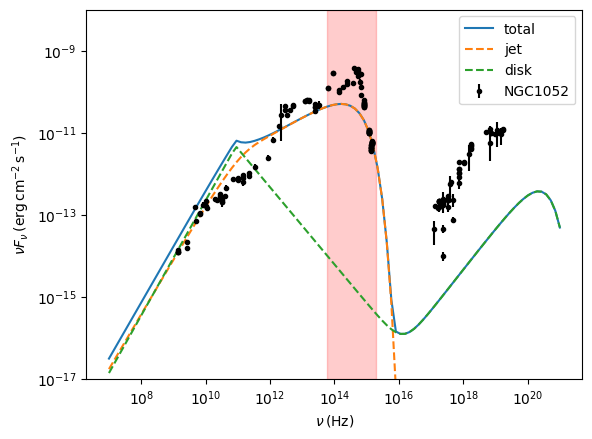

In [147]:
fig, ax = plt.subplots()
best_fit_m = 10 ** disk.log10_m.val
best_fit_m_dot = 10 ** disk.log10_m_dot.val
print(best_fit_m, best_fit_m_dot)

nu = np.logspace(7, 21, 100)

ax.plot(
    nu,
    mdl(nu),
    ls="-",
    label="total",
)
ax.plot(
    nu,
    jet(nu),
    ls="--",
    label="jet",
)
ax.plot(
    nu,
    disk(nu),
    ls="--",
    label="disk",
)
ax.errorbar(
    x_new,
    y_new,
    yerr=yerr_new,
    ls="",
    marker=".",
    color="k",
    label="NGC1052"
)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(sed_x_label)
ax.set_ylabel(sed_y_label)
ax.set_ylim([1e-17, 1e-8])
#ax.plot(x_test, disk_y)
#ax.plot(x_test, jet_y)
ax.fill_betweenx([1e-17, 1e-8], nu_min_fit, nu_max_fit, color="red", alpha=0.2)
ax.legend()
plt.savefig("NGC1052_jet_disk.png", dpi = 300, bbox_inches = 'tight')
plt.show()

2880361862.392384 1.553488713978234e-05


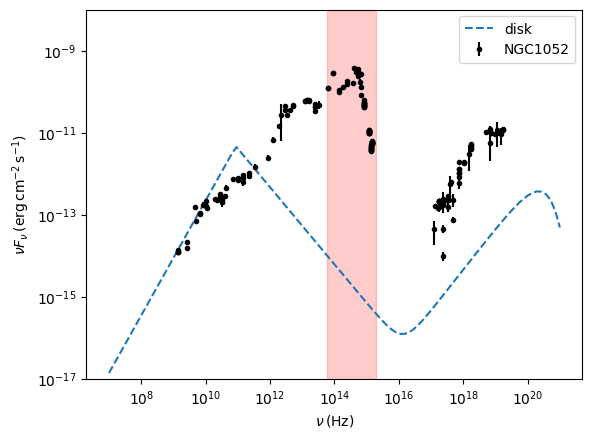

In [148]:
fig, ax = plt.subplots()
best_fit_m = 10 ** disk.log10_m.val
best_fit_m_dot = 10 ** disk.log10_m_dot.val
print(best_fit_m, best_fit_m_dot)

nu = np.logspace(7, 21, 100)

ax.plot(
    nu,
    disk(nu),
    ls="--",
    label="disk",
)
ax.errorbar(
    x_new,
    y_new,
    yerr=yerr_new,
    ls="",
    marker=".",
    color="k",
    label="NGC1052"
)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(sed_x_label)
ax.set_ylabel(sed_y_label)
ax.set_ylim([1e-17, 1e-8])
#ax.plot(x_test, disk_y)
#ax.plot(x_test, jet_y)
ax.fill_betweenx([1e-17, 1e-8], nu_min_fit, nu_max_fit, color="red", alpha=0.2)
ax.legend()
plt.savefig("NGC1052_only_disk.png", dpi = 300, bbox_inches = 'tight')
plt.show()